In [1]:
import numpy as np
from NonlinearController.mpc_utils import *
from NonlinearController.controllers import *
from NonlinearController.model_utils import *
from NonlinearController.lpv_embedding import *
from NonlinearController.systems import UnbalancedDisc
import deepSI
import random

In [2]:
# import state space encoder network and set required parameters
model = deepSI.load_system("NonlinearController/trained_models/unbalanced/ObserverUnbalancedDisk_dt01_nab_4_SNR_30_e250")
dt = 0.1

nx = model.nx
nu = model.nu if model.nu is not None else 1
ny = model.ny if model.ny is not None else 1

In [3]:
# function for generating random magnitude step inputs
def randomLevelReference(Nsim, nt_range, level_range):
    x_reference_list = np.array([])
    Nsim_remaining = Nsim
    while True:
        Nsim_steps = random.randint(nt_range[0],nt_range[1])
        Nsim_remaining = Nsim_remaining - Nsim_steps
        x_reference_list = np.hstack((x_reference_list, np.ones(Nsim_steps)*random.randint(level_range[0]*10,level_range[1]*10)/10))

        if Nsim_remaining <= 0:
            x_reference_list = x_reference_list[:Nsim]
            break
    return x_reference_list

In [4]:
# determine input for a simulation length
sim_steps = 800
# w = np.random.normal(size=(nu,sim_steps))*2
# w = np.hstack((np.zeros((nu,sim_steps//2)),2*np.ones((nu,sim_steps//2 + sim_steps%2))))#
w = randomLevelReference(sim_steps, [40,50], [-3, 3])[np.newaxis]

In [5]:
# declare system and run simulation using input
system = UnbalancedDisc(dt=0.1)
system.reset_state()

log_z = np.zeros((ny,sim_steps))

for i in range(sim_steps):
    z = system.measure_act(w[0,i])
    log_z[:,i] = z

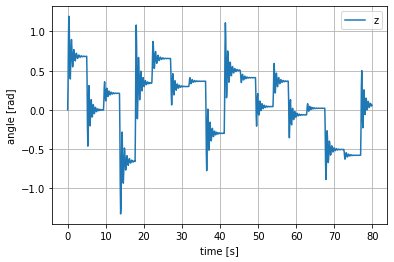

In [6]:
# plot simulation of system
plt.plot(np.arange(sim_steps)*dt, log_z[0,:], label='z')
plt.ylabel("angle [rad]")
plt.xlabel("time [s]")
plt.grid()    
plt.legend(loc='upper right');

In [7]:
# declare the normalization from the model and normalize the input
norm = model.norm
u = norm_input(w, norm)

In [8]:
# CasADi function
x_cas = MX.sym("x",nx,1)
u_cas = MX.sym("u",nu,1)

# convert torch nn to casadi function
x_rhs = CasADi_Fn(model, x_cas, u_cas)
f = Function('f', [x_cas, u_cas], [x_rhs])
y_rhs = CasADi_Hn(model, x_cas)
h = Function('h', [x_cas], [y_rhs])

In [9]:
# simulate using CasADi functions of state space encoder
x0 = np.zeros((nx,1))
u0 = np.zeros((nu,1))

log_y = np.zeros((ny,sim_steps))

for i in range(sim_steps):
    u0[:,0] = u[:,i]
    
    log_y[:,i] = h(x0)
    
    x0[:,:] = f(x0, u0)
    

0.036260927610783485

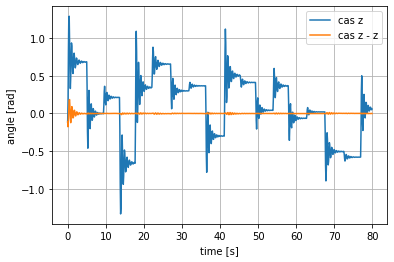

In [10]:
# plot simulation of CasADi function
cas_log_z = denorm_output(log_y, norm)

plt.plot(np.arange(sim_steps)*dt, cas_log_z[0,:], label='cas z')
plt.plot(np.arange(sim_steps)*dt, cas_log_z[0,:] - log_z[0,:], label='cas z - z')
plt.ylabel("angle [rad]")
plt.xlabel("time [s]")
plt.grid()    
plt.legend(loc='upper right');

np.sqrt(np.mean(np.square(cas_log_z[0,:] - log_z[0,:]))) / np.std(log_z[0,:])

In [11]:
# LPV embedding and simulation
lpv_A, lpv_B, lpv_C, corr_f, corr_h = lpv_embedding(model, n_stages=5)
f0 = np.array(corr_f.elements())[np.newaxis].T
h0 = np.array(corr_h.elements()) #make sure this has the correct dimensions for ny>1

A = np.zeros((nx,nx))
B = np.zeros((nx,nu))
C = np.zeros((ny,nx))

x0 = np.zeros((nx,1))
u0 = np.zeros((nu,1))

log_y = np.zeros((ny,sim_steps))

for i in range(sim_steps):
    u0[:,0] = u[:,i] #for x1

    A[:,:] = lpv_A(x0,u0) #for x1
    B[:,:] = lpv_B(x0,u0) #for x1
    C[:,:] = lpv_C(x0,u0) #for y0

    log_y[:,i] = C @ x0[:,0] + h0 #y0

    x0 = A @ x0 + B @ u0 + f0 #x1

0.0058987217448273725

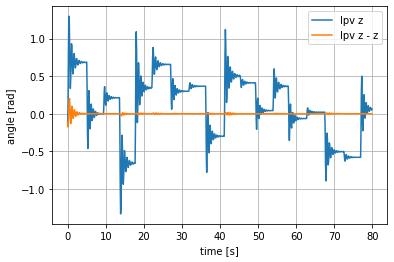

In [12]:
# plot simulation of lpv model
lpv_log_z = denorm_output(log_y, norm)

plt.plot(np.arange(sim_steps)*dt, lpv_log_z[0,:], label='lpv z')
plt.plot(np.arange(sim_steps)*dt, lpv_log_z[0,:] - log_z[0,:], label='lpv z - z')
plt.ylabel("angle [rad]")
plt.xlabel("time [s]")
plt.grid()    
plt.legend(loc='upper right');

np.sqrt(np.mean(np.square(lpv_log_z[0,:] - cas_log_z[0,:]))) / np.std(log_z[0,:])

In [13]:
# Velocity LPV embedding
lpv_A, lpv_B, lpv_C = velocity_lpv_embedding(model, n_stages=5)

A = np.zeros((nx,nx))
B = np.zeros((nx,nu))
C = np.zeros((ny,nx))

x0 = np.zeros((nx,1))
dx0 = np.zeros((nx,1))

u0 = np.zeros((nu,1))
u_1 = np.zeros((nu,1))
du0 = np.zeros((nu,1))

y0 = np.zeros((ny,1))
y_1 = np.zeros((ny,1))

vel_log_y = np.zeros((ny,sim_steps))

for i in range(sim_steps):
    u0 = u[:,i]
    du0 = u0 - u_1

    x0[:,:] = dx0 + x0[:,:]

    A[:,:] = lpv_A(x0,dx0,u0,du0)
    B[:,:] = lpv_B(x0,dx0,u0,du0)
    C[:,:] = lpv_C(x0,dx0,u0,du0)

    y0[:,:] = y_1 + C @ dx0
    dx0[:,:] = A @ dx0 + B @ du0

    vel_log_y[:,i] = y0

    u_1[:,:] = u[:,i]
    y_1[:,:] = y0
    # if i < 0:
    #     y_1[:,:] = log_y[:,i]
    # else:
    #     y_1[:,:] = y0

0.06824422358501268

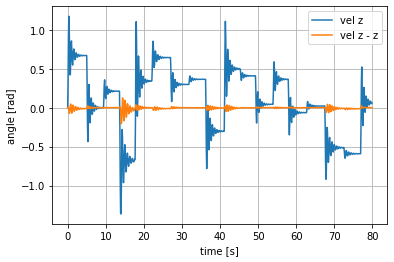

In [14]:
vel_log_z = denorm_output(vel_log_y, norm)

plt.plot(np.arange(sim_steps)*dt, vel_log_z[0,:], label='vel z')
plt.plot(np.arange(sim_steps)*dt, vel_log_z[0,:] - log_z[0,:], label='vel z - z')
plt.ylabel("angle [rad]")
plt.xlabel("time [s]")
plt.grid()    
plt.legend(loc='upper right');

np.sqrt(np.mean(np.square(vel_log_z[0,:] - cas_log_z[0,:]))) / np.std(log_z[0,:])

In [ ]:
plt.plot(lpv_log_z[0,:] - vel_log_z[0,:])
np.sqrt(np.mean(np.square(lpv_log_z[0,:] - vel_log_z[0,:]))) / np.std(log_z[0,:])